# polarity

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

## Clearing db

In [2]:
from snorkel.models.meta import clear_database
clear_database()

## Parsing

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

### Define Parser

In [4]:
import os
from snorkel.parser import CorpusParser, HTMLParser, OmniParser
from snorkel.utils import get_ORM_instance
from snorkel.queries import split_corpus

docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_html/'
pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_pdf/'
doc_parser = HTMLParser(path=docs_path)
context_parser = OmniParser(pdf_path=pdf_path, visual=True, session=session)
cp = CorpusParser(doc_parser, context_parser, max_docs=10) 

### Run Parser

In [5]:
%time corpus = cp.parse_corpus(name='Hardware', session=session)

session.add(corpus)
session.commit()

[========================================] 100%
CPU times: user 4.34 s, sys: 184 ms, total: 4.53 s
Wall time: 15.9 s


### Split Corpus

In [6]:
from snorkel.models import Corpus

corpus = get_ORM_instance(Corpus, session, 'Hardware')
split_corpus(session, corpus, train=0.6, development=0.4, test=0, seed=3)

6 Documents added to corpus Hardware Training
4 Documents added to corpus Hardware Development


## Extraction

In [7]:
from snorkel.models import candidate_subclass

Part_Polarity = candidate_subclass('Part_Polarity', ['part','polarity'])

### Define Matchers

In [8]:
from snorkel.matchers import RegexMatchSpan, Union

eeca_matcher = RegexMatchSpan(rgx='([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z\/]{0,5}[0-9]?[A-Z]?([-][A-Z0-9]{1,7})?([-][A-Z0-9]{1,2})?)')
jedec_matcher = RegexMatchSpan(rgx='([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)')
jis_matcher = RegexMatchSpan(rgx='(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})')
others_matcher = RegexMatchSpan(rgx='((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)')
parts_matcher = Union(eeca_matcher, jedec_matcher, jis_matcher, others_matcher)

polarity_matcher = RegexMatchSpan(rgx=r'(pnp|npn)', ignore_case=True)

### Define ContextSpaces

In [9]:
from snorkel.candidates import OmniNgrams
from hardware_utils import OmniNgramsPart, get_gold_dict
from collections import defaultdict
import os

# Make parts list
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
gold_parts = get_gold_dict(gold_file, doc_on=True, part_on=True, val_on=False)
parts_by_doc = defaultdict(set)
for part in gold_parts:
    parts_by_doc[part[0]].add(part[1])

part_ngrams = OmniNgramsPart(n_max=3, parts_by_doc=None) # NOTE: linking is turned off
polarity_ngrams = OmniNgrams(n_max=1)

### Run CandidateExtractor

In [10]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance
ce = CandidateExtractor(Part_Polarity, 
                        [part_ngrams, polarity_ngrams], 
                        [parts_matcher, polarity_matcher], 
                        throttler=None)

for corpus_name in ['Hardware Training', 'Hardware Development']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = ce.extract(\
        corpus.documents, corpus_name + ' Candidates', session)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

Extracting Candidates from Corpus (Hardware Training)
[========================================] 100%
CPU times: user 804 ms, sys: 4 ms, total: 808 ms
Wall time: 993 ms
Candidate Set (Hardware Training Candidates) contains 399 Candidates
Extracting Candidates from Corpus (Hardware Development)
[========================================] 100%
CPU times: user 428 ms, sys: 16 ms, total: 444 ms
Wall time: 526 ms
Candidate Set (Hardware Development Candidates) contains 130 Candidates


### Assess Recall

In [11]:
from snorkel.models import Candidate
from hardware_utils import entity_level_total_recall

all_candidates = session.query(Candidate).all()
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
(tp, fp, fn) = entity_level_total_recall(
    all_candidates, gold_file, 'polarity', relation=True)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Total Recall
Entity-level Candidates extracted: 93 
Entity-level Gold: 829
Intersection Candidates: 52
----------------------------------------
Overlap with Gold:  0.0627



In [12]:
from pprint import pprint
pprint(fn)
print len(fn)

set([('112823', 'BC546', 'NPN'),
     ('112823', 'BC546B', 'NPN'),
     ('112823', 'BC546BG', 'NPN'),
     ('112823', 'BC546BRL1', 'NPN'),
     ('112823', 'BC546BRL1G', 'NPN'),
     ('112823', 'BC546BZL1G', 'NPN'),
     ('112823', 'BC547', 'NPN'),
     ('112823', 'BC547A', 'NPN'),
     ('112823', 'BC547ARL', 'NPN'),
     ('112823', 'BC547ARLG', 'NPN'),
     ('112823', 'BC547AZL1G', 'NPN'),
     ('112823', 'BC547B', 'NPN'),
     ('112823', 'BC547BG', 'NPN'),
     ('112823', 'BC547BRL1G', 'NPN'),
     ('112823', 'BC547BZL1G', 'NPN'),
     ('112823', 'BC547C', 'NPN'),
     ('112823', 'BC547CG', 'NPN'),
     ('112823', 'BC547CZL1G', 'NPN'),
     ('112823', 'BC548', 'NPN'),
     ('112823', 'BC548B', 'NPN'),
     ('112823', 'BC548BG', 'NPN'),
     ('112823', 'BC548BRL1G', 'NPN'),
     ('112823', 'BC548BZL1G', 'NPN'),
     ('112823', 'BC548C', 'NPN'),
     ('112823', 'BC548CG', 'NPN'),
     ('112823', 'BC548CZL1G', 'NPN'),
     ('2N3906', '2N3906', 'PNP'),
     ('2N3906', '2N3906BU', 'PNP'),


## Gold Labels

In [13]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
for set_name in ['Training', 'Development']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           'polarity')
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

Loading 399 candidate labels
[========================================] 100%
CPU times: user 996 ms, sys: 24 ms, total: 1.02 s
Wall time: 1.14 s
327/399 Candidates in Candidate Set (Hardware Training Candidates) have positive Labels
Loading 130 candidate labels
[========================================] 100%
CPU times: user 512 ms, sys: 20 ms, total: 532 ms
Wall time: 576 ms
67/130 Candidates in Candidate Set (Hardware Development Candidates) have positive Labels


### Assess Baseline Performance

In [14]:
# from snorkel.models import Corpus, Candidate
# from snorkel.utils import get_ORM_instance
# from snorkel.lf_helpers import *
# from hardware_utils import entity_level_f1
# from itertools import chain

# def LF_all_true(c):
#     return True

# def LF_complement_nearby(c):
#     return 1 if set(['complement','complementary']).isdisjoint(
#         chain.from_iterable(
#             [get_phrase_ngrams(c.part), 
#              get_phrase_ngrams(c.polarity),
#              get_neighbor_phrase_ngrams(c.polarity)])) else 0

# candidates = session.query(Candidate).all()
# (tp, fp, tn, fn) = baseline(candidates, LF_complement_nearby)

# corpus = get_ORM_instance(Corpus, session, 'Hardware')
# gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
# (TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, corpus, 'polarity')

In [15]:
# from pprint import pprint
# pprint(FP)

In [16]:
# pprint(FN)

In [17]:
# from hardware_utils import entity_to_candidates

# print len(candidates)
# matches = entity_to_candidates((u'SIEMS01215-1', u'BC856', u'NPN'), candidates)
# c = matches[0]
# print c

In [18]:
# from snorkel.models import ImplicitSpan
# from snorkel.lf_helpers import *
# phrases = []
# print list(get_neighbor_phrase_ngrams(c.polarity))
# print c.polarity.parent
# print phrases
# print "SPAN_TYPE_[%s]" % ('IMPLICIT' if isinstance(c.polarity, ImplicitSpan) else 'EXPLICIT')
# # list(get_phrase_ngrams(c.polarity))

## Features

### Extract Features

In [19]:
from snorkel.models import CandidateSet
from snorkel.fast_annotations import FeatureManager
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

feature_manager = FeatureManager()
%time F_train = feature_manager.create(session, train, 'Train Features')
%time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

[========================================] 100%
Bulk upserting 241180 annotations...
Done.
Loading sparse Feature matrix...
CPU times: user 8.86 s, sys: 516 ms, total: 9.37 s
Wall time: 19.3 s
[========================================] 100%
Bulk upserting 35576 annotations...
Done.
Loading sparse Feature matrix...
CPU times: user 3.42 s, sys: 172 ms, total: 3.59 s
Wall time: 5.12 s


In [38]:
from snorkel.candidates import CandidateSet
ex  = session.query(CandidateSet).filter(CandidateSet.name ==  'Hardware Training Candidates').one()
cs = ex.candidates
print cs[10]
print cs.slice(0,10)[0]
print cs.slice(10,20)[0]

Part_Polarity(Span("PZT3904", parent=345, chars=[16,22], words=[2,2]), Span("NPN", parent=346, chars=[30,32], words=[6,6]))
Part_Polarity(Span("DTC114YE", parent=6, chars=[0,7], words=[0,0]), Span("NPN", parent=17, chars=[0,2], words=[0,0]))
Part_Polarity(Span("PZT3904", parent=345, chars=[16,22], words=[2,2]), Span("NPN", parent=346, chars=[30,32], words=[6,6]))


## LFs

In [21]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Polarity = candidate_subclass('Part_Polarity', ['part','polarity'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()

### Define LFs

In [22]:
from snorkel.fast_annotations import LabelManager
from snorkel.lf_helpers import *
import re
label_manager = LabelManager()

LFs = []

def LF_complement_phrase_part(c):
    return -1 if overlap(['complement','complementary'], 
                         get_phrase_ngrams(c.part)) else 0
LFs.append(LF_complement_phrase_part)

def LF_complement_phrase_polarity(c):
    return -1 if overlap(['complement','complementary'], 
                         get_phrase_ngrams(c.polarity)) else 0
LFs.append(LF_complement_phrase_polarity)

def LF_complement_neighbor_polarity(c):
    return -1 if overlap(['complement','complementary'], 
                         get_neighbor_phrase_ngrams(c.polarity)) else 0
LFs.append(LF_complement_neighbor_polarity)

def LF_top_mark_col_part(c):
    return -1 if overlap(['top','mark'],
                         get_col_ngrams(c.part)) else 0
LFs.append(LF_top_mark_col_part)

def LF_endswith_D_part(c):
    return -1 if c.part.get_span().endswith('D') else 0
LFs.append(LF_endswith_D_part)

def LF_default_positive(c):
    return 1 if not overlap(['complement','complementary'],
                            chain.from_iterable([
                            get_phrase_ngrams(c.part),
                            get_phrase_ngrams(c.polarity),
                            get_neighbor_phrase_ngrams(c.polarity)])) else 0
LFs.append(LF_default_positive)

In [23]:
from snorkel.models import Candidate
from hardware_utils import entity_to_candidates

candidates = session.query(Candidate).all()
print len(candidates)
# matches = entity_to_candidates((u'SIEMS01215-1', u'BC856', u'NPN'), candidates)
# c = matches[0]
c = candidates[0]
print candidates[0]

print LF_complement_phrase_part(c)
print LF_complement_phrase_polarity(c)
print LF_complement_neighbor_polarity(c)
print LF_top_mark_col_part(c)
print LF_endswith_D_part(c)
print LF_default_positive(c)

529
Part_Polarity(Span("DTC114YE", parent=6, chars=[0,7], words=[0,0]), Span("NPN", parent=17, chars=[0,2], words=[0,0]))
0
0
0
0
0
1


### Apply LFs

In [24]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%
Bulk upserting 2394 annotations...
Done.
Loading sparse Label matrix...
CPU times: user 1.58 s, sys: 36 ms, total: 1.62 s
Wall time: 1.8 s


<399x6 sparse matrix of type '<type 'numpy.float64'>'
	with 414 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [25]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()
%time L_train.lf_stats(train_gold)

[========================================] 100%
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 39.6 ms


,accuracy,conflicts,coverage,j,overlaps
LF_complement_phrase_part,1.000000,0.000000,0.035088,0,0.035088
LF_complement_phrase_polarity,1.000000,0.000000,0.062657,1,0.000000
LF_complement_neighbor_polarity,0.104348,0.000000,0.576441,2,0.035088
LF_top_mark_col_part,NaN,0.000000,0.000000,3,0.000000
LF_endswith_D_part,1.000000,0.002506,0.002506,4,0.002506
LF_default_positive,0.840278,0.002506,0.360902,5,0.002506


## Learn and Evaluate

In [26]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Polarity = candidate_subclass('Part_Polarity', ['part','polarity'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [27]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=15000, rate=1e-2)
%time gen_model.save(session, 'Generative Params')
train_marginals = gen_model.marginals(L_train)

/home/xiao/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using gpu device 0: GeForce GTX 980 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5005)


Training marginals (!= 0.5):	399
Features:			6
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.040699
	Learning epoch = 250	Gradient mag. = 0.045391
	Learning epoch = 500	Gradient mag. = 0.047990
	Learning epoch = 750	Gradient mag. = 0.050629
	Learning epoch = 1000	Gradient mag. = 0.053299
	Learning epoch = 1250	Gradient mag. = 0.055994
	Learning epoch = 1500	Gradient mag. = 0.058708
	Learning epoch = 1750	Gradient mag. = 0.061438
	Learning epoch = 2000	Gradient mag. = 0.064179
	Learning epoch = 2250	Gradient mag. = 0.066930
	Learning epoch = 2500	Gradient mag. = 0.069690
	Learning epoch = 2750	Gradient mag. = 0.072457
	Learning epoch = 3000	Gradient mag. = 0.075231
	Learning epoch = 3250	Gradient mag. = 0.078012
	Learning epoch = 3500	Gradient mag. = 0.080799
	Learning epoch = 3750	Gradient mag. = 0.083593
	Learning epoch = 4000	Gradient mag. = 0.086393
	Learning epoch = 4250	Gradient mag. = 0.089200
	Learning epoch = 4500	Gradient mag. = 0.092012
	Learnin

In [28]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-5)
%time disc_model.save(session, "Discriminative Params")

Training marginals (!= 0.5):	399
Features:			4022
Using gradient descent...
	Learning epoch = 0	Step size = 1e-05
	Loss = 276.565725	Gradient magnitude = 2166.216205
	Learning epoch = 100	Step size = 9.04792147114e-06
	Loss = 121.395621	Gradient magnitude = 71.825514
	Learning epoch = 200	Step size = 8.18648829479e-06
	Loss = 118.849424	Gradient magnitude = 45.494711
	Learning epoch = 300	Step size = 7.40707032156e-06
	Loss = 117.706177	Gradient magnitude = 36.668708
	Learning epoch = 400	Step size = 6.70185906007e-06
	Loss = 116.991867	Gradient magnitude = 32.308055
	Learning epoch = 500	Step size = 6.06378944861e-06
	Loss = 116.484274	Gradient magnitude = 29.718267
	Learning epoch = 600	Step size = 5.48646907485e-06
	Loss = 116.100672	Gradient magnitude = 28.019308
	Learning epoch = 700	Step size = 4.96411413431e-06
	Loss = 115.800469	Gradient magnitude = 26.865767
	Learning epoch = 800	Step size = 4.4914914861e-06
	Loss = 115.560538	Gradient magnitude = 26.093012
	Learning epoch = 9

In [29]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()

In [30]:
dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates -- Gold').one()

In [31]:
from snorkel.models import CandidateSet
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Development Labels -- Gold')

Calibration plot:


/home/xiao/software/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


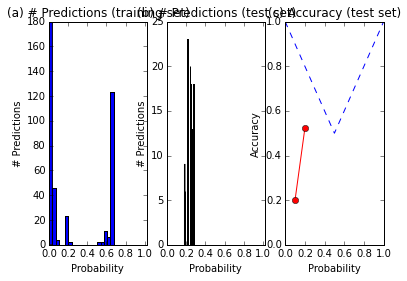

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | TN: 63 | FN: 67

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | TN: 63 | FN: 67



In [32]:
tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [33]:
from snorkel.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Development').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, corpus, 'polarity')

Scoring on Entity-Level Gold Data
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | FN: 32



In [34]:
from pprint import pprint
FP_list = sorted(list(FP))
pprint(FP_list[:10])

[]


In [35]:
print disc_model.get_feature_weights(F_dev)

[(u'TAB_e2_NEIGHBOR_PHRASE_WORDS_[pnp]', -0.0501637698387066), (u'VIZ_e2_PAGE_[1]', -0.03810835349405602), (u'TAB_e2_NEIGHBOR_PHRASE_WORDS_[pnp transistors]', -0.031226082778114554), (u'TAB_e2_NEIGHBOR_PHRASE_WORDS_[complementary pnp]', -0.031226082778114554), (u'TAB_e2_NEIGHBOR_PHRASE_WORDS_[complementary]', -0.031226082778114554), (u'TAB_e2_NEIGHBOR_PHRASE_WORDS_[recommended complementary]', -0.031226082778114554), (u'VIZ_e2_ALIGNED_characteristic', 0.026297737943929148), (u'VIZ_e2_ALIGNED_LEFT_sperrschicht', 0.026297737943929148), (u'VIZ_e2_ALIGNED_sperrschicht', 0.026297737943929148), (u'TAB_e2_RIGHT_WORDS_[transistors]', 0.026297737943929148), (u'VIZ_e2_ALIGNED_LEFT_point', 0.026297737943929148), (u'VIZ_e2_ALIGNED_current', 0.026297737943929148), (u'VIZ_e2_ALIGNED_junction', 0.026297737943929148), (u'VIZ_e2_ALIGNED_LEFT_frequency', 0.026297737943929148), (u'VIZ_e2_ALIGNED_capacitance', 0.026297737943929148), (u'TAB_e2_LEFT_WORDS_[recommended]', 0.026297737943929148), (u'VIZ_e2_ALI

In [36]:
from hardware_utils import entity_to_candidates

entity = FP_list[0]
matches = entity_to_candidates(entity, fp)
print "Entity: (%d matches)" % len(matches)
print entity

candidate = matches[0]
print "\nCandidate:"
print candidate

print "\nScore:"
print disc_model.get_candidate_score(candidate, F_dev)

print "\nFeatures:"
pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

IndexError: list index out of range

In [ ]:
from hardware_utils import part_error_analysis
part_error_analysis(candidate)